In [ ]:
# Modules
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

import nltk
import re
import random

#
rcParams['figure.figsize'] = 20.7,8.27 
sb.set_style("whitegrid")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

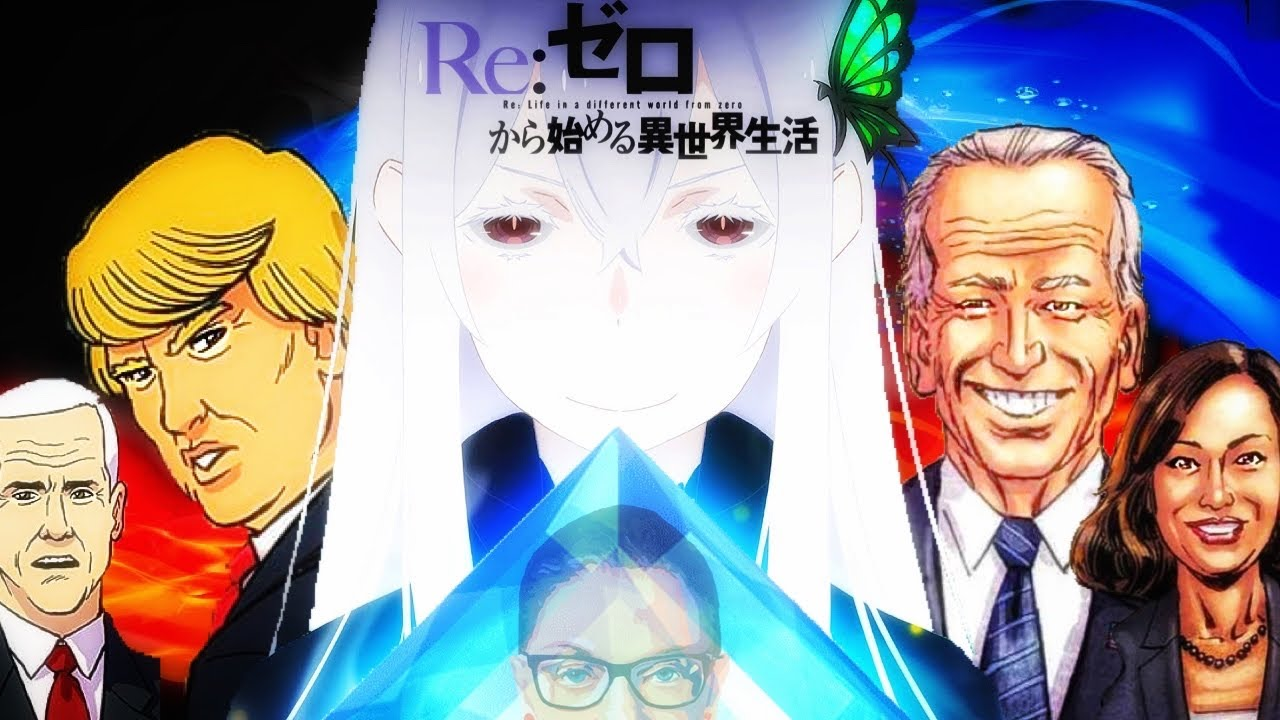

# Twitter reaction to the Season finale of the 2020 Election (End of the Trump Biden ARC)

Quick Navigation
* [1. Getting a feel for the data (Data Exploration)](#1)
* [2. Hashtags (Word Clouds)](#2)
* [3. Sentiment Analysis with some more Word Clouds](#3)
* [4. Topic Modeling (In-progress)](#4)

One of my first few notebooks, comments, suggestions and criticisms are all welcome :)

<a id="1"></a>
# 1. Data Exploration


In [ ]:
# read the data
donald_df = pd.read_csv("../input/us-election-2020-tweets/hashtag_donaldtrump.csv", lineterminator='\n')
biden_df = pd.read_csv("../input/us-election-2020-tweets/hashtag_joebiden.csv", lineterminator='\n')

# Combine into 1 Dataframe
donald_df["hashtag"] = "trump"
biden_df["hashtag"] = "biden"
df = pd.concat([donald_df, biden_df])

# overt to datetime format
df["created_at"] = pd.to_datetime(df.created_at) 

In [ ]:
df.head()

Lets check if there are any duplicates

In [ ]:
#check for duplicates
print("Count of duplicates: {}".format(df.duplicated(subset=["tweet"]).sum()))

It seems there are quite a bit of duplicates present

Few thoughts on this:
* Dropping duplicates wont help as the original tweet will be assigned to just 1 candidate, duplicates may be better off removed all together.
* Removing duplicates may not be enough, #Trump tweets still mention biden without the hashtag. We would need to remove all tweets that mention both in the same tweet

In [ ]:
# Dropping all duplicates
print("Original size of df: {}".format(len(df)))
df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(df)))

In [ ]:
sb.catplot(x="hashtag", y="count", kind="bar", palette=['r', 'b'],data=pd.DataFrame(df[["hashtag"]].value_counts()).reset_index().rename(columns={0:"count"}))


It seems there are more tweets tagged with #Trump than #Biden. Now lets look at it over a period of time

In [ ]:
# Hashtag Timeline
timeline = df.resample('D', on='created_at')["hashtag"].value_counts().unstack(1)

timeline.reset_index(inplace=True)

timeline = timeline.melt("created_at", var_name='hashtag',  value_name='vals')

sb.set_style("whitegrid")
sb.lineplot(x="created_at", y="vals", hue="hashtag", data=timeline, palette=["b", "r"])

Something to note is that we still have tweets that mention both candidates in the same sentence altough one of them without the hashtag.

So this still presents a problem for something like sentiment analysis as we can't determine to whom the polarity is directed towards if both trump and biden are present in the same text. It may be good idea to later remove tweets that mention both candidates when doing sentiment analsysis or topic modeling, although the drawback is we would be dropping quite a bit of data.

## Top 10 Countries 

In [ ]:
# Top 10 countries 
df["country"] = df["country"].replace({"United States":"United States of America"})
data = df[(df.country.isin(df.country.value_counts()[:10].index))].groupby(["country", "hashtag"]).count().sort_values(by=["user_id"], ascending=False)["user_id"].reset_index()


ax=sb.catplot(x="country", y="user_id", hue="hashtag", kind="bar", aspect=20.5/8.27,palette=['r', 'b'], data=data)
ax.set_xticklabels(rotation=30)

## Top 10 States

In [ ]:
ax=sb.catplot(x="state", y="user_id", hue="hashtag", kind="bar", aspect=20.5/8.27, palette=['r', 'b'],
              data = df[(df.country == "United States of America") & (df.state.isin(df.state.value_counts()[:15].index))].groupby(["state", "hashtag"])
                  .count()
                  .sort_values(by=["user_id"], ascending=False)["user_id"]
                  .reset_index())
ax.set_xticklabels(rotation=30)

## Top 10 People with Highest Followers who tweet trump or biden

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 16), sharex=True)
sb.barplot(x="user_followers_count", y="user_name", orient="h", ax=ax1, palette=["r"],
           data=df[(df.hashtag == "trump")]\
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers_count"], ascending=False)[["user_name", "user_followers_count"]][:10])
ax1.set_title('People with Highest Followers who tweet #trump')

sb.barplot(x="user_followers_count", y="user_name", orient="h", ax=ax2, palette=["b"],
           data=df[(df.hashtag == "biden")]
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers_count"], ascending=False)[["user_name", "user_followers_count"]][:10])
ax2.set_title('People with Highest Followers who tweet #biden')
fig.show()

It seems public reach of a celebrity endorsement contributed quite alot for #biden

## Likes, Retweets and user_followers distribution

Next I wanted to take a look at the density distribution for likes and user_followers who use either hashtags. 
Here I just limited the outliers by removing data that are below the .999 percentile in the dataframe

In [ ]:
ax = sb.stripplot(data=df[df.user_followers_count < df.user_followers_count.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],
                  x="user_followers_count",
                  y="hashtag")
ax.set_title("User Follower counts")

In [ ]:
ax = sb.stripplot(data=df[df.retweet_count < df.retweet_count.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],
                  x="retweet_count",
                  y="hashtag")
ax.set_title("Retweet counts")

In [ ]:
ax= sb.stripplot(data=df[df.likes < df.likes.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],
                 x="likes",
                 y="hashtag")
ax.set_title("Likes count")

<a id="2"></a>
# Hashtags associated with Trump and Biden

Here I want to take a look specifically at hashtags people use when associating a tweet with trump or biden

In [ ]:
# Helper functions

def get_hashtags(df):
    df["hashtags"] = df.tweet.apply(lambda x: ",".join([tag.strip("#") for tag in x.split() if tag.startswith("#")]))
    allhashtags = ",".join(df["hashtags"].values.tolist()).split(",")
    allhashtags = [i.upper() for i in allhashtags if i != ""]
    
    return allhashtags

def generate_wordcloud(text, color_func, max_words=100, font_path="../input/us-elections-external-data/TypoSlab Irregular shadowed_demo.otf"):
    
    wordcloud = WordCloud(width=2560, 
                          height=800,
                          max_font_size=200, 
                          max_words=max_words, 
                          background_color="white",
                          collocations=False,
                          color_func=color_func,
                          font_path=font_path).generate(text)
    
    plt.figure(figsize=(29,9))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
def random_red_color_func(word=None, *args, **kwargs):
    h = int(11)
    s = 100
    l = int(float(random.randint(30, 65)))

    return "hsl({}, {}%, {}%)".format(h, s, l)

def random_blue_color_func(word=None, *args, **kwargs):
    h = int(245)
    s = 100
    l = int(float(random.randint(20, 65)))

    return "hsl({}, {}%, {}%)".format(h, s, l)

First lets take a look at the top hashtags

In [ ]:
allhashtags = get_hashtags(df) #creates a list of all the hashtags (text that starts with #)

In [ ]:
pd.Series(allhashtags).value_counts()[:30].sort_values(ascending=True).plot(kind="barh")

Most of these hashtags seem to be redundant and dont really offer anything new. To fix this, I have created a sample of stopwords to remove and filter out the redundant hashtags.

So lets see what are the hashtags filtered if I take out some of the redundant hashtags

In [ ]:
stophashtags = ["trump", "biden", "joebiden", "election2020", "donaldtrump","elections2020", "election", "ellecciones","elecciones", "republican", "democrat", "usa"]

filtered_hashtags = [tags for tags in allhashtags if (not any([x in tags.lower() for x in stophashtags]))]

pd.Series(filtered_hashtags).value_counts()[:30].sort_values(ascending=True).plot(kind="barh")

Okay this looks a little bit better. 

### Now lets make some wordclouds

In [ ]:
trump_hastags = get_hashtags(df[df.hashtag == "trump"].copy())

# Filter trump hashtags
filtered_trump_hashtags = [tags for tags in trump_hastags if (not any([x in tags.lower() for x in stophashtags]))]
text = " ".join(filtered_trump_hashtags)

#color red
generate_wordcloud(text, random_red_color_func)

In [ ]:
biden_hastags = get_hashtags(df[df.hashtag == "biden"].copy())

# Filter trump hashtags
filtered_biden_hastags = [tags for tags in biden_hastags if (not any([x in tags.lower() for x in stophashtags]))]
text = " ".join(filtered_trump_hashtags)

#color blue
generate_wordcloud(text, random_blue_color_func)

Interesting to see that #MAGA is associated in both trump and biden hashtags, maybe an indicator to the success of MAGA as a catchy marketing/campaign slogan.

<a id="3"></a>
# Diving into some sentiment

So my objective here is to try and get the most polirizing tweets and remove neutral tweets. 
Before running sentiment analysis, I wanted to clean out all tweets that mention both trump and biden in the same text. Just so we can properly attach the polarity of a tweet to either of them

In [ ]:
stop_words = stopwords.words('english')

# Text cleaning
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[#+_$]')
STOPWORDS = set(stopwords.words('english'))
LINKS = r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)'

def regex_strip(s):
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    s = s.lower()
    s = re.sub(r'&gt|&lt', ' ', s)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    s = re.sub(r'\(.*?\)', '. ', s)
    s = re.sub(r'product received for free[.| ]', ' ', s)
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def textCleaner(text):
    text = re.sub("‘", '', text)
    text = re.sub("#", '', text)
    text = re.sub(LINKS, '', text, flags=re.MULTILINE) #remove links
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # remove mentions
    text = re.sub(REPLACE_BY_SPACE_RE, "", text)
    text = re.sub(BAD_SYMBOLS_RE, "", text)
    tokenized_words = text.split()
    
    string_list = []
    for string in tokenized_words:
        if string not in STOPWORDS:
            string_list.append(regex_strip(string))

    return (" ".join(string_list))

In [ ]:
# Run the text cleaner
df["clean_tweet"] = df.tweet.apply(lambda x: textCleaner(x))
df["clean_tweet_length"] = df.tweet.apply(lambda x: len(x))

In [ ]:
regex = re.compile(r"^(?=.*trump)(?=.*biden)")

mask = df.clean_tweet.apply(lambda x: False if regex.match(x) else True)

filtered_df = df[mask]

filtered_df["polarity"] = [TextBlob(tweet).polarity for tweet in filtered_df.clean_tweet.values ]
filtered_df["subjectivity"] = [TextBlob(tweet).subjectivity for tweet in filtered_df.clean_tweet.values ]

## Now lets look at what a negative wordcloud of hashtags on trump looks like

In [ ]:
trump_hastags = get_hashtags(filtered_df[(filtered_df.hashtag=="trump") & (filtered_df.polarity<-0.5)].copy())

# Filter trump hashtags
filtered_trump_hashtags = [tags for tags in trump_hastags if (not any([x in tags.lower() for x in stophashtags]))]
text = " ".join(filtered_trump_hashtags)

#color red
generate_wordcloud(text, random_red_color_func)

## So what does negative Biden hashtags look like

In [ ]:
biden_hastags = get_hashtags(filtered_df[(filtered_df.hashtag=="biden") & (filtered_df.polarity<-0.5)].copy())

# Filter biden hashtags
filtered_biden_hashtags = [tags for tags in biden_hastags if (not any([x in tags.lower() for x in stophashtags]))]
text = " ".join(filtered_biden_hashtags)

#color red
generate_wordcloud(text, random_blue_color_func)

TODO: How about top Bigrams for both hashtags

<a id="4"></a>
# Topic Modeling for both sides (In-progress)